# IMAGE FOLDER NAME

In [ ]:
folder_name = "train_10/"
#folder_name = "train/"

# Precursor (setup/install)

In [ ]:
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

Mounted at /content/drive/


In [ ]:
!pip -q install tensorflow tensorflow-gpu opencv-python matplotlib keras

  Preparing metadata (setup.py) ... done
  error: subprocess-exited-with-error
  
  × python setup.py bdist_wheel did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  ERROR: Failed building wheel for tensorflow-gpu
  error: subprocess-exited-with-error
  
  × Running setup.py install for tensorflow-gpu did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Running setup.py install for tensorflow-gpu ... error
error: legacy-install-failure

× Encountered error while trying to install package.
╰─> tensorflow-gpu

note: This is an issue with the package mentioned above, not pip.
hint: See above for output from the failure.


In [ ]:
import os
import tensorflow as tf
from tensorflow import keras
import pandas as pd
from keras import layers
import matplotlib
import pathlib
import cv2
import imghdr
import time
from matplotlib import pyplot as plt
import numpy as np
from keras.models import Sequential, load_model # MAY NEED TO BE REPLACED W/ FUNCTIONAL API
from keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout, AveragePooling2D
from keras.metrics import Precision, Recall, BinaryAccuracy
from PIL import Image

In [ ]:

gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True) # /OOM error

# Global Variables

## image data

In [ ]:
size = 256#512
img_height, img_width = size,size
image_height, image_width = size, size
data_dir = 'drive/MyDrive/Colab Notebooks/Polyamanita/data/'+folder_name
image_extensions = ['jpg', 'jpeg', 'png'] # every file ends with jpg, but it's found to be a jpeg instead...

## epoch / batch

In [ ]:
epochs = 250 # early stops implimented
batch_size = int(size/4)#int(size/8) #16 #32

## train_ds / val_ds

In [ ]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)
    
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 3610 files belonging to 10 classes.
Using 2888 files for training.
Found 3610 files belonging to 10 classes.
Using 722 files for validation.


In [ ]:
class_names = train_ds.class_names
num_classes = len(class_names)

# Autotuning

In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

# Data Augmentation

In [ ]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
    tf.keras.layers.experimental.preprocessing.RandomZoom(0.1),
])

# Create the Model

In [ ]:
preprocess_input_mobilenet_v2 = tf.keras.applications.mobilenet_v2.preprocess_input

In [ ]:
base_model = tf.keras.applications.MobileNetV2(input_shape=(size, size, 3), include_top=False, weights='imagenet')

9406464/9406464 [==============================] - 0s 0us/step


In [ ]:
base_model.trainable = False
    
image_batch, label_batch = next(iter(train_ds))
feature_batch = base_model(image_batch)
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)

prediction_layer = tf.keras.layers.Dense(num_classes, kernel_regularizer=tf.keras.regularizers.l2(0.001))
prediction_batch = prediction_layer(feature_batch_average)

inputs = tf.keras.Input(shape=(size, size, 3))

x = data_augmentation(inputs)
x = preprocess_input_mobilenet_v2(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)

outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [ ]:
ckpt_directory = 'drive/MyDrive/Colab Notebooks/Polyamanita/checkpoints/'+folder_name
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=ckpt_directory,
                                                 save_weights_only=True,
                                                 verbose=1,
                                                 save_freq=3
)

In [ ]:
# callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3) # study more into this
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50) # TODO: try this 

# Compile Model

In [ ]:
model.compile(optimizer='adam',
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  metrics=['accuracy'])

# Train Model

In [ ]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    callbacks=[callback, cp_callback],
)

Epoch 1/250


46/46 [==============================] - 56s 1s/step - loss: 1.8038 - accuracy: 0.3750 - val_loss: 1.2083 - val_accuracy: 0.6454
Epoch 2/250
46/46 [==============================] - 13s 278ms/step - loss: 1.1211 - accuracy: 0.6420 - val_loss: 0.9359 - val_accuracy: 0.7271
Epoch 3/250
46/46 [==============================] - 13s 279ms/step - loss: 0.9162 - accuracy: 0.7126 - val_loss: 0.8253 - val_accuracy: 0.7590
Epoch 4/250
46/46 [==============================] - 13s 279ms/step - loss: 0.8205 - accuracy: 0.7445 - val_loss: 0.7679 - val_accuracy: 0.7715
Epoch 5/250
46/46 [==============================] - 13s 275ms/step - loss: 0.7496 - accuracy: 0.7607 - val_loss: 0.7363 - val_accuracy: 0.7756
Epoch 6/250
46/46 [==============================] - 13s 276ms/step - loss: 0.7177 - accuracy: 0.7756 - val_loss: 0.7159 - val_accuracy: 0.7825
Epoch 7/250
46/46 [==============================] - 13s 274ms/step - loss: 0.6800 - accuracy: 0.7829 - val_loss: 0.7020 - val_accuracy: 0.7909
Epoch 8

# Save the Model

In [ ]:
model_save = model

In [ ]:
checkpoint = 'drive/MyDrive/Colab Notebooks/Polyamanita/checkpoints/'
for file in os.listdir(checkpoint):
    os.remove(checkpoint + file)

In [ ]:
# i = 1
model_directory = 'drive/MyDrive/Colab Notebooks/Polyamanita/models/'+folder_name

In [ ]:
model.save(model_directory+'/savedmodel')

In [ ]:
model.save(model_directory+'/savedmodel.h5')

In [ ]:
os.listdir(model_directory)

['savedmodel', 'savedmodel.h5']

In [ ]:
# TODO: save class_names into a file ()

# Kill Runtime

# View Performance Graph

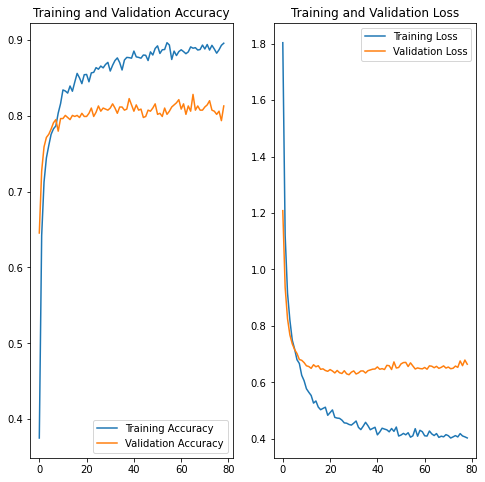

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(79)#epochs) # callback cucks this

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()